In [18]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import folium
from shapely.geometry import Point
from statsmodels.tsa.seasonal import seasonal_decompose
import os

pd.set_option('display.max_rows', 500)


In [19]:
path_to_file = os.path.join('data', 'processed_data.csv')
df = pd.read_csv(path_to_file)
df["DATE_TIME"] = pd.to_datetime(df["DATE_TIME"], format='mixed')
df.head()

,SITE_ID,LOCATION,DATE_TIME,NO,NOX,NO2,PM2_5,PM10,Latitude,Longitude
0,188,AURN Bristol Centre,1993-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,51.457204,-2.585649
1,188,AURN Bristol Centre,1993-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,51.457204,-2.585649
2,188,AURN Bristol Centre,1993-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,51.457204,-2.585649
3,188,AURN Bristol Centre,1993-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,51.457204,-2.585649
4,188,AURN Bristol Centre,1993-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,51.457204,-2.585649


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1607930 entries, 0 to 1607929
Data columns (total 10 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   SITE_ID    1607930 non-null  int64         
 1   LOCATION   1607930 non-null  object        
 2   DATE_TIME  1607930 non-null  datetime64[ns]
 3   NO         1478294 non-null  float64       
 4   NOX        1471958 non-null  float64       
 5   NO2        1469173 non-null  float64       
 6   PM2_5      150898 non-null   float64       
 7   PM10       357573 non-null   float64       
 8   Latitude   1607930 non-null  float64       
 9   Longitude  1607930 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 122.7+ MB


Searching for sites that have data a year before and after the implementation of the Clear Air Zone

In [21]:
start_date = '2021-11-28 00:00:00'
end_date = '2023-11-28 00:00:00'

site_date_ranges = df.groupby('SITE_ID')['DATE_TIME'].agg(['min', 'max'])

full_coverage_sites = site_date_ranges[
    (site_date_ranges['min'] <= start_date) & 
    (site_date_ranges['max'] >= end_date)
].index.tolist()

sensors_with_full_coverage = df[df['SITE_ID'].isin(full_coverage_sites)]

sensor_coords = sensors_with_full_coverage[['SITE_ID', 'Latitude', 'Longitude']].drop_duplicates()

print(sensor_coords)

         SITE_ID   Latitude  Longitude
113910       203  51.441747  -2.559956
500141       215  51.432676  -2.604957
699392       270  51.427864  -2.563742
1158036      452  51.462829  -2.584541
1333866      463  51.478045  -2.535230
1475905      500  51.457950  -2.583989
1535088      501  51.455269  -2.596649
1586005      672  51.459142  -2.595433


Plotting these sites

In [22]:
coords_df = sensor_coords

coords_df = coords_df.drop_duplicates()

map_center = [coords_df['Latitude'].mean(), coords_df['Longitude'].mean()]

sites_map = folium.Map(location=map_center, zoom_start=12)

for index, row in coords_df.iterrows():
    popup_text = f"Lat: {row['Latitude']:.6f}<br>Long: {row['Longitude']:.6f}"

    folium.Marker(
        location = [row['Latitude'], row['Longitude']],
        popup=popup_text,
        tooltip=f"Point {row['SITE_ID']}"
    ).add_to(sites_map)

caz_geojson_url = os.path.join('data', 'weca_caz.geojson')

folium.GeoJson(
    caz_geojson_url,
    name='Bristol Clean Air Zone',
    style_function=lambda x: {
        'fillColor': '#4169E1', 
        'color': 'darkblue',
        'weight': 2,
        'fillOpacity': 0.15
    }
).add_to(sites_map)

folium.LayerControl().add_to(sites_map)

sites_map

In [23]:
gdf = gpd.read_file(caz_geojson_url)
target_area = gdf.geometry.iloc[0]

sites_inside_caz = []
sites_outside_caz = []

for row in sensor_coords.values:
    point = Point(row[2], row[1])

    is_inside = target_area.contains(point)

    if is_inside:
        sites_inside_caz.append(row[0])
    else:
        sites_outside_caz.append(row[0])


print(sites_inside_caz)
print(sites_outside_caz)

[500.0, 501.0, 672.0]
[203.0, 215.0, 270.0, 452.0, 463.0]


Cell used for visualising specific data

/var/folders/_k/0mgp9cxj72dcxh4819b8hd740000gn/T/ipykernel_6073/2273883766.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('H')


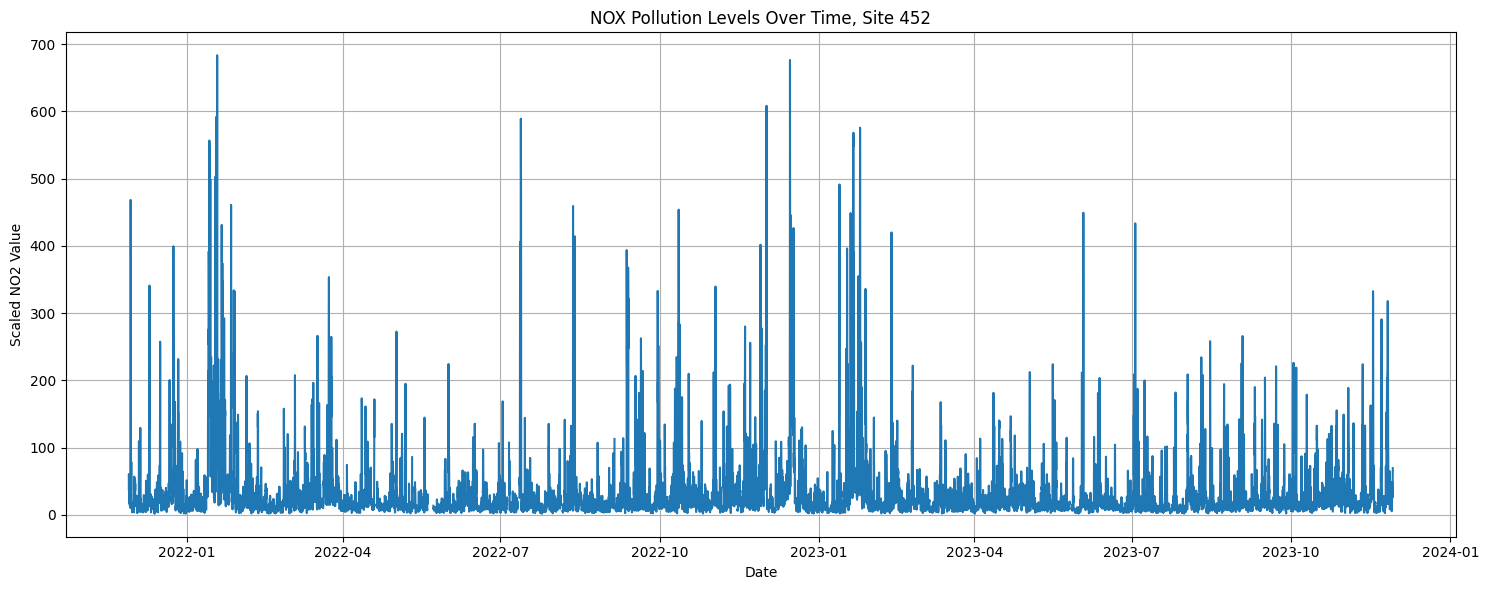

In [24]:
site_no = 452
pollution_type = 'NOX'
start_date = '2021-11-28 07:00:00'
end_date = '2023-11-28 18:00:00'

filter = (df['SITE_ID'] == site_no) & (df['DATE_TIME'].between(start_date, end_date))

site_data = (
    df[filter]
    .set_index('DATE_TIME')
    .sort_index()[pollution_type]
    .resample('H')
    .mean()
    # .interpolate(method='linear')
)

plt.figure(figsize=(15, 6))
plt.plot(site_data)
plt.title(f'{pollution_type} Pollution Levels Over Time, Site {site_no}')
plt.xlabel('Date')
plt.ylabel('Scaled NO2 Value')
plt.grid(True)
plt.tight_layout()

Helper function to calculate the mean pollutant concentration before and after CAZ implementation

In [25]:
def calculate_before_after_caz(sites, pollutants, start_date='2021-11-28 00:00:00', end_date='2023-11-28 00:00:00'):
    caz_start = '2022-11-28 00:00:00'

    site_data = {}

    for site in sites:
        site_data[site] = {'before': {}, 'after': {}}

        for pollutant in pollutants:
            site_data_before = (
                df[(df['SITE_ID'] == site) & (df['DATE_TIME'].between(start_date, caz_start))]
                .set_index('DATE_TIME')
                .sort_index()[pollutant]
                .resample('H')
                .mean()
                .interpolate(method='linear')
            )

            before_mean = site_data_before.mean()

            site_data_after = (
                df[(df['SITE_ID'] == site) & (df['DATE_TIME'].between(caz_start, end_date))]
                .set_index('DATE_TIME')
                .sort_index()[pollutant]
                .resample('H')
                .mean()
                .interpolate(method='linear')
            )

            after_mean = site_data_after.mean()

            site_data[site]['before'][pollutant] = before_mean
            site_data[site]['after'][pollutant] = after_mean

    return site_data

Helper function to visualise changes in pollutant concentration

In [26]:
def show_graphs(inside_caz, start_date='2021-11-28 00:00:00', end_date='2023-11-28 00:00:00'):
    if inside_caz:
        sites = sites_inside_caz
    else:
        sites = sites_outside_caz
    pollutants = ['NO', 'NOX', 'NO2', 'PM10']

    site_data = calculate_before_after_caz(sites, pollutants, start_date, end_date)

    bar_width = 0.35
    x = np.arange(len(pollutants))

    num_sites = len(sites)
    rows = int(np.ceil(np.sqrt(num_sites)))
    cols = int(np.ceil(num_sites / rows))

    fig, axes = plt.subplots(3, 3, figsize=(12, 10))
    axes = axes.flatten()

    for i, site in enumerate(sites):
        ax = axes[i]
        data = site_data[site]

        before_values = [data['before'][p] for p in pollutants]
        after_values = [data['after'][p] for p in pollutants]

        ax.bar(x - bar_width/2, before_values, bar_width, label='Before CAZ', color='skyblue')
        ax.bar(x + bar_width/2, after_values, bar_width, label='After CAZ', color='lightgreen')

        ax.set_xlabel('Pollutant Type')
        ax.set_ylabel('Average Concentration')
        ax.set_title(f'Site {site}')
        ax.set_xticks(x)
        ax.set_xticklabels(pollutants)
        ax.legend(title='Time Period')
        ax.grid(axis='y', linestyle='--')


    for j in range(num_sites, len(axes)):
        fig.delaxes(axes[j])

    if inside_caz:
        plt.suptitle('Pollution Levels Inside CAZ Before and After CAZ Implementation')
    else:
        plt.suptitle('Pollution Levels Outside CAZ Before and After CAZ Implementation')
    plt.tight_layout()
    plt.show()

/var/folders/_k/0mgp9cxj72dcxh4819b8hd740000gn/T/ipykernel_6073/2088200339.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('H')
/var/folders/_k/0mgp9cxj72dcxh4819b8hd740000gn/T/ipykernel_6073/2088200339.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('H')


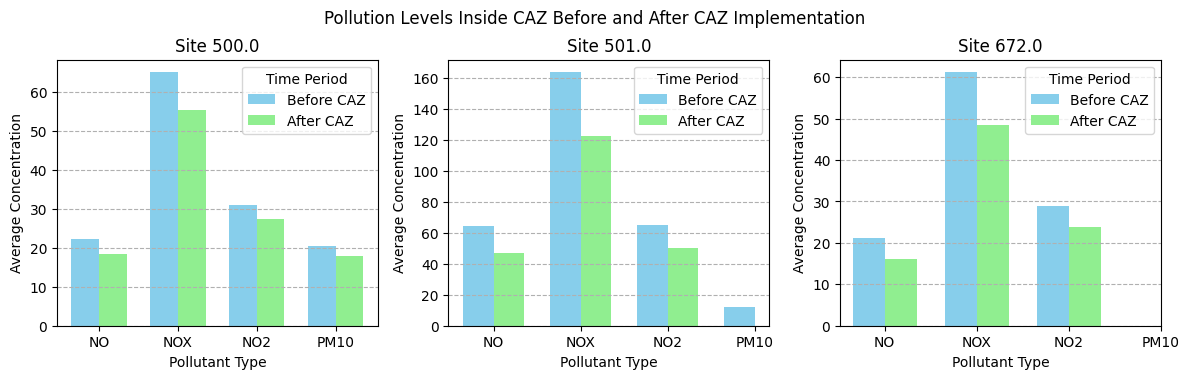

In [27]:
show_graphs(inside_caz=True)

/var/folders/_k/0mgp9cxj72dcxh4819b8hd740000gn/T/ipykernel_6073/2088200339.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('H')
/var/folders/_k/0mgp9cxj72dcxh4819b8hd740000gn/T/ipykernel_6073/2088200339.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('H')


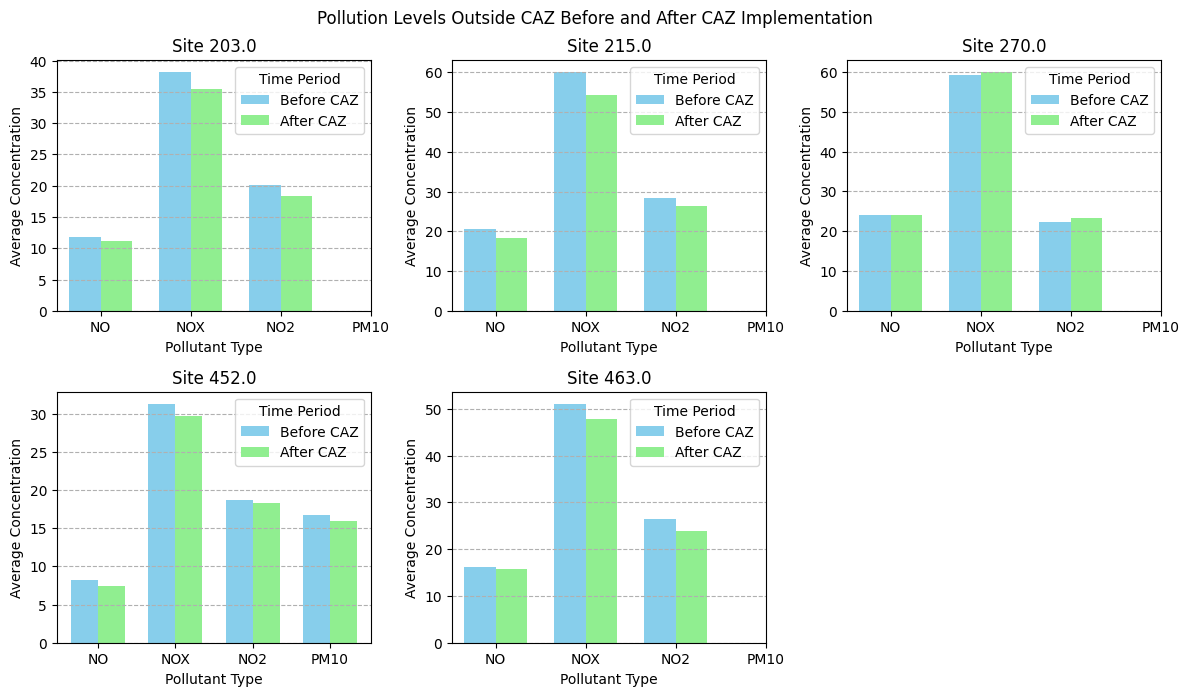

In [28]:
show_graphs(inside_caz=False)

/var/folders/_k/0mgp9cxj72dcxh4819b8hd740000gn/T/ipykernel_6073/2088200339.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('H')
/var/folders/_k/0mgp9cxj72dcxh4819b8hd740000gn/T/ipykernel_6073/2088200339.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('H')


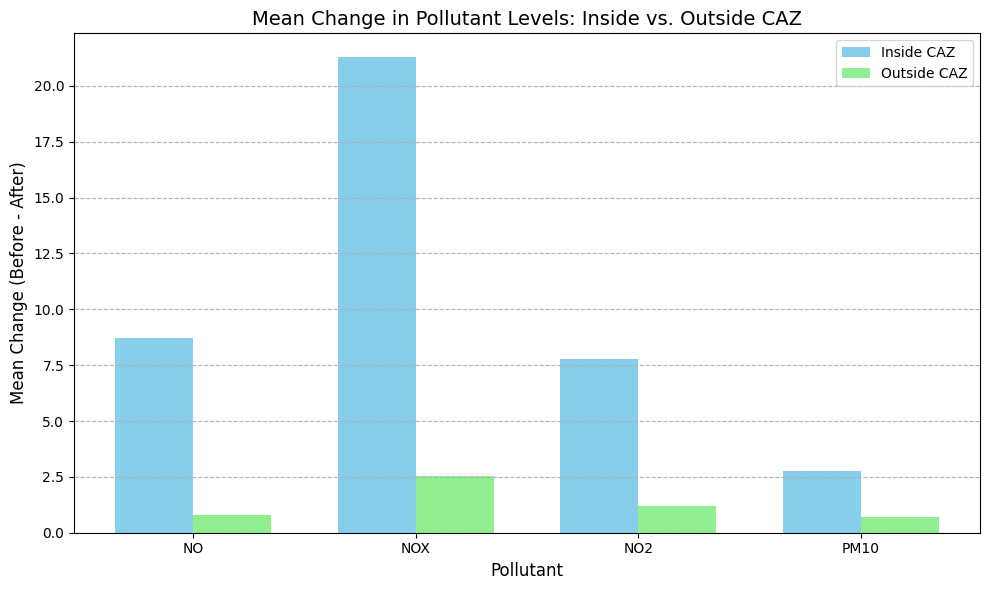

In [33]:
pollutants = ['NO', 'NOX', 'NO2', 'PM10']

site_data_outside_caz = calculate_before_after_caz(sites_outside_caz, pollutants, start_date, end_date)

site_data_inside_caz = calculate_before_after_caz(sites_inside_caz, pollutants, start_date, end_date)

change_means_inside = []
change_means_outside = []

for pollutant in pollutants:
    change_values_inside = []
    change_values_outside = []

    for site in sites_inside_caz:
        data = site_data_inside_caz.get(site)
        if data:
            before_val = data['before'].get(pollutant)
            after_val = data['after'].get(pollutant)
            if before_val is not None and after_val is not None:
                change = before_val - after_val
                change_values_inside.append(change)
    
    for site in sites_outside_caz:
        data = site_data_outside_caz.get(site)
        if data:
            before_val = data['before'].get(pollutant)
            after_val = data['after'].get(pollutant)
            if before_val is not None and after_val is not None:
                change = before_val - after_val
                change_values_outside.append(change)

    change_means_inside.append(np.nanmean(change_values_inside) if change_values_inside else 0)
    change_means_outside.append(np.nanmean(change_values_outside) if change_values_outside else 0)

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = np.arange(len(pollutants))

ax.bar(index - bar_width/2, change_means_inside, bar_width, label='Inside CAZ', color='skyblue')
ax.bar(index + bar_width/2, change_means_outside, bar_width, label='Outside CAZ', color='lightgreen')

ax.set_xlabel('Pollutant', fontsize=12)
ax.set_ylabel('Mean Change (Before - After)', fontsize=12)
ax.set_title('Mean Change in Pollutant Levels: Inside vs. Outside CAZ', fontsize=14)
ax.set_xticks(index)
ax.set_xticklabels(pollutants)
ax.legend()
ax.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.savefig(os.path.join('img', 'Mean_Change_Pollutant_Levels_CAZ_vs_NonCAZ.png'))
plt.show()

/var/folders/_k/0mgp9cxj72dcxh4819b8hd740000gn/T/ipykernel_6073/3823173624.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('H')


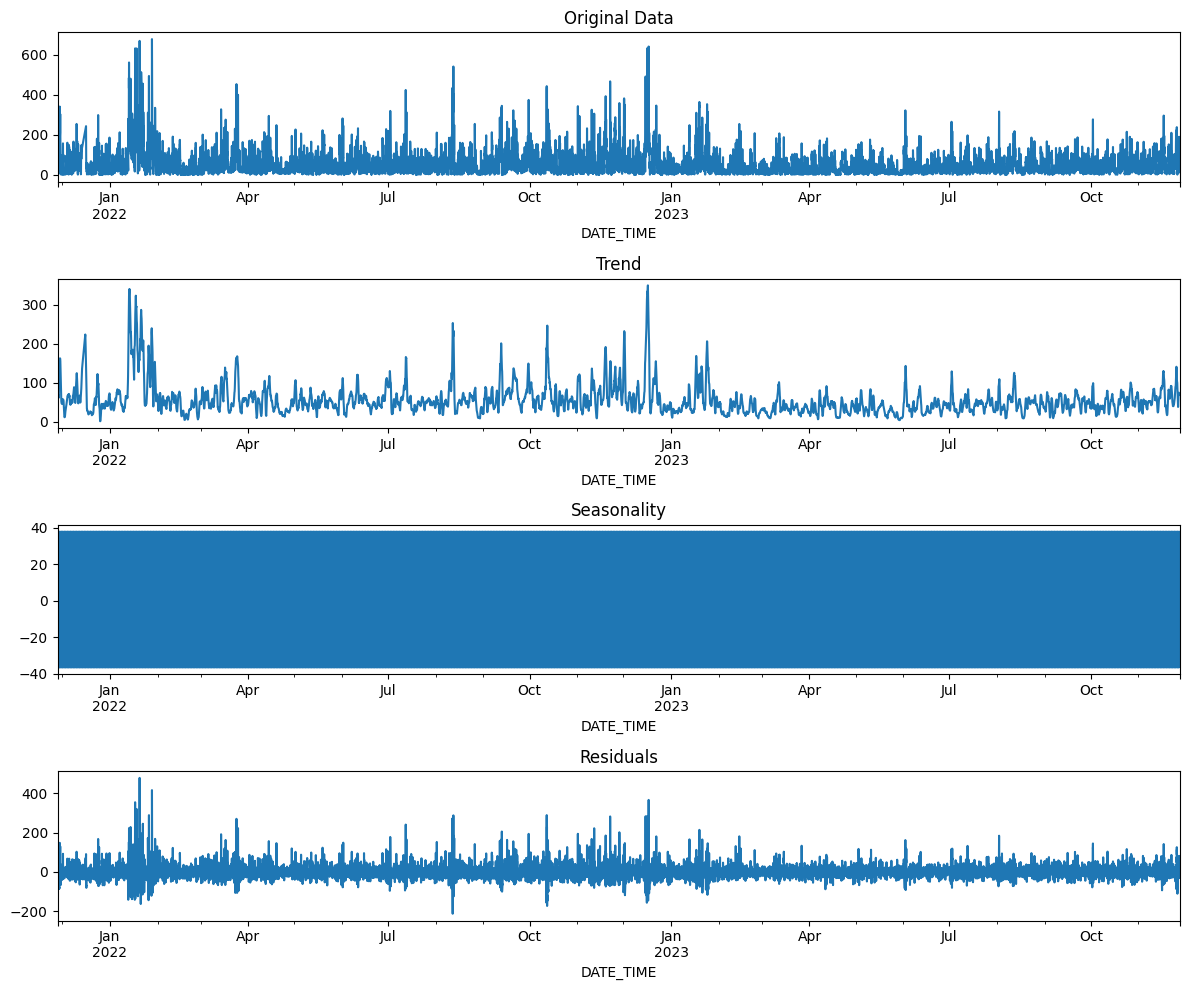

In [30]:
site_no = 501.0
pollution_type = 'NO'
start_date = '2021-11-28 00:00:00'
end_date = '2023-11-28 00:00:00'

filter = (df['SITE_ID'] == site_no) & (df['DATE_TIME'].between(start_date, end_date))

site_data = (
    df[filter]
    .set_index('DATE_TIME')
    .sort_index()[pollution_type]
    .resample('H')
    .interpolate(method='linear')
)

decomposition = seasonal_decompose(site_data, model='additive', period=24)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))

decomposition.observed.plot(ax=ax1)
ax1.set_title('Original Data')

decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')

decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonality')

decomposition.resid.plot(ax=ax4)
ax4.set_title('Residuals')

plt.tight_layout()
plt.show()

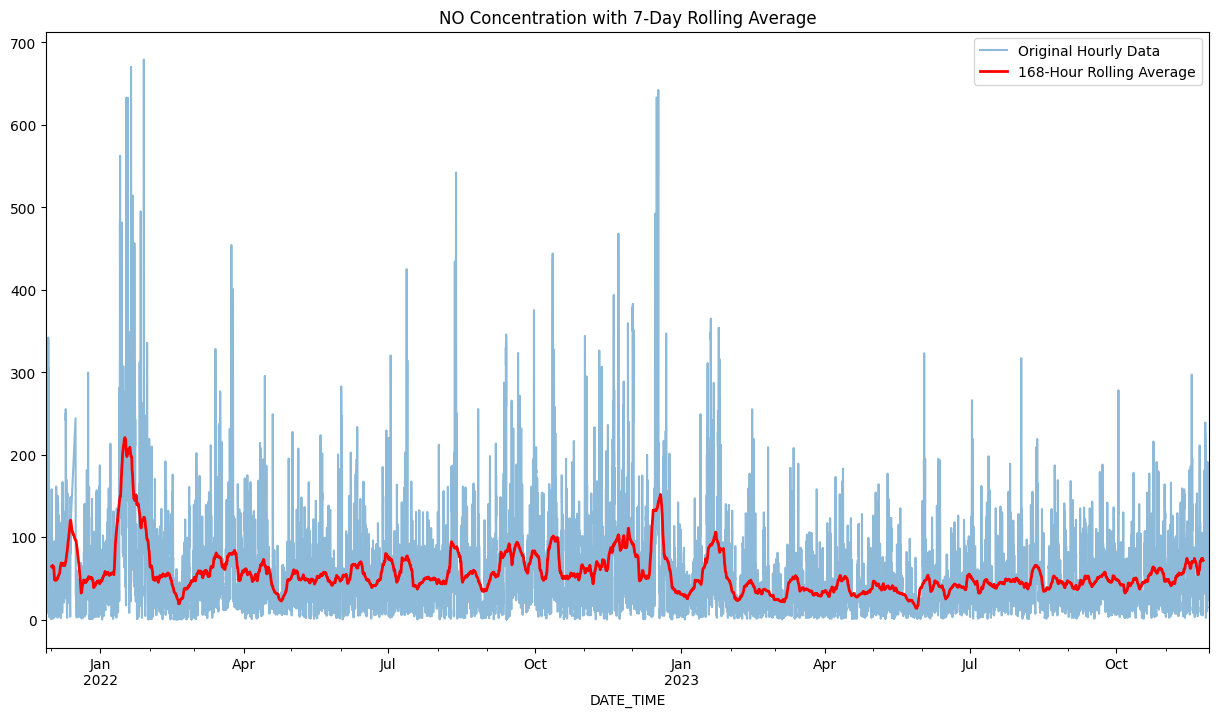

In [31]:
rolling_avg_168 = site_data.rolling(window=168, center=True).mean()

plt.figure(figsize=(15, 8))
site_data.plot(label='Original Hourly Data', alpha=0.5)
rolling_avg_168.plot(label='168-Hour Rolling Average', color='red', linewidth=2)
plt.title('NO Concentration with 7-Day Rolling Average')
plt.legend()
plt.show()